# Introducrtion to Machine Learning: Assignment #3
## Submission date: 09\07\2024, 23:55.
### Topics:
- Multiclass Classification
- PAC, VCdim
- Bias vs Variance
- Cross validation
- Linear Regression
- Decision Trees

Submitted by:

 Samih warwar 324888155

 Merry Shalabi 324007202

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Multiclass SVM

You will implement and compare different multiclass methods in both separable and non separable cases.

In [ ]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics


As seen in tutorials, One vs One is usually a better choice than other methods, even SKlearn uses it! <br/>
You are given a partial implementation of OvO classifier and need to complete it. Specifically:<br/>
- ```__init__(self, n_classes=2, C=1.0)``` - Init $\binom{n}{2}$ estimators, one for each pair of classes.

- ```fit(self, X, y)``` - given data and labels learns the classifiers using linear SVM. <br/>

- ```predict(self, X)``` - as learned in lectures, prediction for sample will be the majority class got most votes from all the classifiers.  Therefore, $\forall i<j$ predict who is the winner for X in the estimator $(i,j)$ and update the bins accordinly.

In [ ]:
from collections import defaultdict
class OneVsOneClassifier:
    def __init__(self, n_classes=2, C=1.0):
        self.n_classes = n_classes
        self.C = C
        # self.estimators = defaultdict(SVC)
        self.estimators = defaultdict(None)
        # self.estimators = defaultdict(lambda: None)


    def fit(self, X, y):
        for i in range(self.n_classes):
            for j in range(i + 1,self.n_classes):
                # choosing the samples...
                mask = (y == i) | (y == j)
                temp_X = X[mask]
                temp_y = y[mask]
                # Create binary labels for the classes
                temp_y = (temp_y == i).astype(int)
                self.estimators[(i,j)] = SVC(C=self.C,kernel='linear')
                self.estimators[(i,j)].fit(temp_X, temp_y)

    def predict(self, X):
        scores = np.zeros((self.n_classes, len(X)))
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                decisions = self.estimators[(i, j)].decision_function(X)
                scores[i, :] += (decisions > 0).astype(int)
                scores[j, :] += (decisions < 0).astype(int)
        return np.argmax(scores, axis=0)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

The data

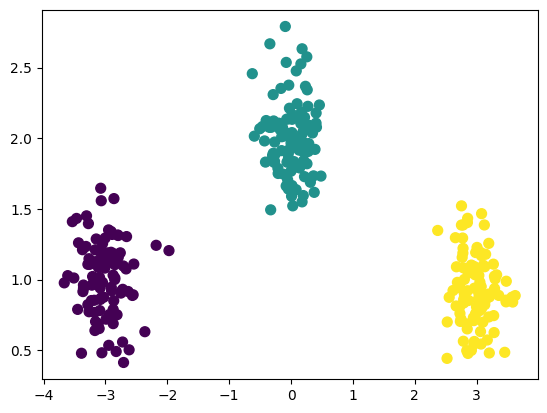

In [ ]:
from sklearn.datasets import make_blobs

np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

This will test the classifier we just built by plotting confusion matrix and draw the decision boundaries. <br/>
Does the value of C matter? <br/>
<font color='red'>Yes,changing the value of $C$ will get us different results due to its importance in maintaining the tradoff between variance and bias.
Low $C$ value leads to uderfitting and high $C$ value will lead to overfitting. But in this specific problem the $C$ will not change the results a lot because the data easly linear separable so a little change in the saperating lines will not make a big effect.</font>

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

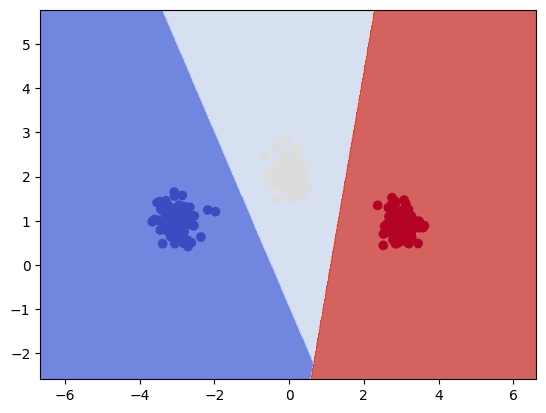

In [ ]:
clf_onevsall = OneVsOneClassifier(n_classes=3, C=2)

clf_onevsall.fit(X,y)

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

metrics.confusion_matrix(y, clf_onevsall.predict(X))

Generate another data



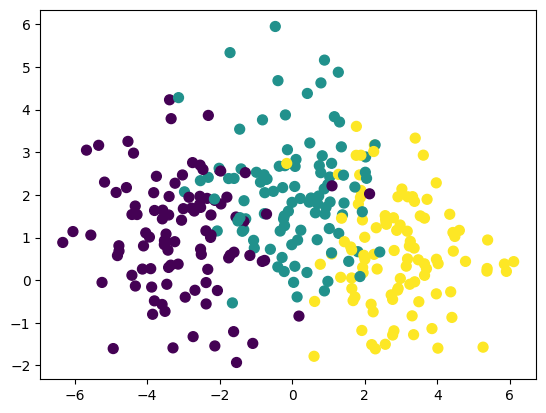

In [ ]:
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=1.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

Look at the train vs test for different values of C. <br/> Justify the plot, by checking what happens as $C\rightarrow 0$, $C\rightarrow \infty$ and mid value C.<br/>
<font color='red'>when $C\rightarrow 0$ we get a wider margin that leads to underfitting and we can see in the plot that we get worse accuracy in both train and test data.and when $C\rightarrow \infty$ will lead to narrow margin that leads to overfitting here too we can see in the plot that we get the highest accuracy in train data but not as good in the test.In the other hand when using mid value $C$(around 1e-2) will get us better results spacially in test.</font>

100%|██████████| 5/5 [00:00<00:00, 68.24it/s]


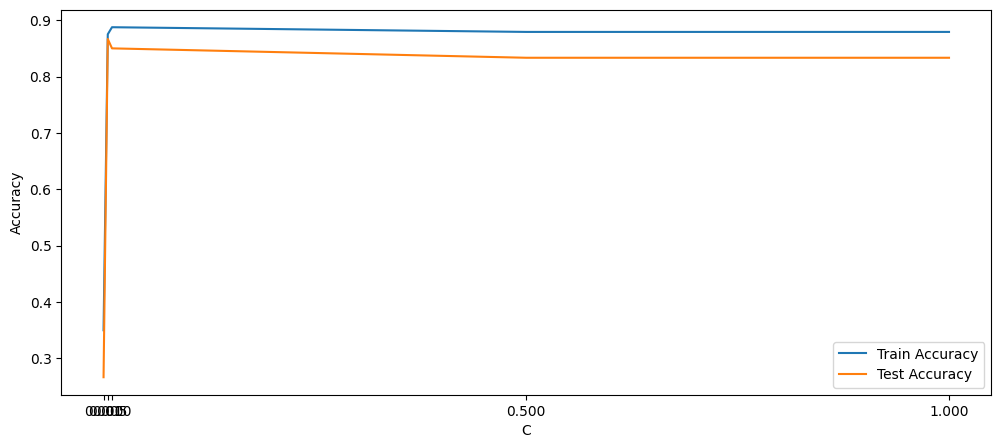

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of C values
# C_values = [5e-3, 1e-2, 0.5, 1]
C_values = [9e-8,5e-3, 1e-2, 0.5, 1]


train_accuracies = []
test_accuracies = []

for C in tqdm(C_values):
    # Create a new OneVsOneClassifier instance
    clf_onevsall = OneVsOneClassifier(n_classes=3, C=C)

    # Fit the classifier on the training data
    clf_onevsall.fit(X_train, y_train)

    # Calculate the train and test accuracies
    train_accuracy = clf_onevsall.score(X_train, y_train)
    test_accuracy = clf_onevsall.score(X_test, y_test)

    # Append the accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the train and test accuracies as a function of C

plt.figure(figsize=(12,5))
plt.plot(C_values, train_accuracies, label="Train Accuracy")
plt.plot(C_values, test_accuracies, label="Test Accuracy")
plt.xlabel("C")
plt.xticks(C_values)
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Now, you will experience little bit from softmax. It uses neural networks, but you dont have to understand it. The importand part is the preidction, which is obtained by:
```
def forward(self, x):
        out = self.linear(x)
        return torch.softmax(out, dim=1)
```
Note that this is exactly that you saw - linear score $s_j$ and then applying softmax.

The best results are obtained using 300 epochs (iterations) and in each iteration the batch size is the entire data. <br/>
1. What happens as you use 100,600 epcohs compared to 300? why is that?
2. Use 300 epochs with batch size 50 vs the entire data. How does the batch size affect the convergence of the problem?

<font color='red'>1. Using low epochs like 100 will cause underfitting because we will not get enongh information about the data therefore will not get good performance. The same way goes when using high rpochs like 600 but here will cause overfitting because we will get noise and too much details therefore poor performance on unseen data.Thus, mid values like 300 epochs will get us the best trade off between generaliaztion and learning.

2.Using a small batch 50 with accordingly high epochs 300 results in faster but noisy results, because then we will be doing too much iterations on small batch but, when using the whole database results in slower but more accurate results, becasue we will have to process bigger dataset.In conlusion using part of the data will get us faster results but not as good as using the whole data even if it runs slower.</font>

In [ ]:
# num_epochs = 300
# batch_size = 50
num_epochs = 300
batch_size = len(X_train)
print(f"Training size is {X_train} samples and batch size is {batch_size}")

Training size is [[ 4.40560358e+00 -8.72299757e-01]
 [ 1.63979804e+00  5.26805585e-02]
 [-4.77652153e+00  8.08131005e-01]
 [ 3.47900558e+00  4.78757314e-01]
 [ 3.97435007e+00  2.28324744e+00]
 [-7.14227010e-01  2.36554008e+00]
 [ 1.81396237e+00  6.68840150e-01]
 [-4.09763487e+00  8.04457287e-01]
 [ 9.82682587e-01  2.24271087e+00]
 [ 3.24532862e+00 -9.48704625e-02]
 [-3.39188525e+00  1.96376467e+00]
 [ 9.34498677e-01  1.70887875e+00]
 [-5.24179448e+00 -5.21842071e-02]
 [-4.85308185e+00  2.05788986e+00]
 [ 1.28523112e+00  1.09765034e+00]
 [ 1.09968175e+00  2.21357665e+00]
 [ 3.37904304e+00 -3.73435559e-02]
 [ 1.97637600e+00  5.84200919e-01]
 [-3.40631204e+00  2.99706867e-01]
 [ 1.93536337e+00  1.60521495e+00]
 [ 2.80698755e+00 -1.18661100e+00]
 [ 1.56056287e+00  4.42841809e-01]
 [-1.54809814e+00  1.48259756e+00]
 [ 1.64181481e+00  7.11353128e-01]
 [ 1.16485920e+00  3.83541517e+00]
 [-3.57750669e+00  1.43861062e+00]
 [ 8.26580210e-02  2.66944794e+00]
 [ 3.64865616e+00  3.83756361e-01]
 [-

In [ ]:
#@title This will train the model using softmax

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Define the simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.linear1.weight.data.fill_(1)
        self.linear1.bias.data.fill_(1)

    def forward(self, x):
        out = self.linear1(x)
        return torch.softmax(out, dim=1)

# Set hyperparameters
input_size = X_train_tensor.shape[1]
output_size = len(torch.unique(y_train_tensor))
learning_rate = 0.01

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Instantiate the model and define the optimizer
model = SimpleNN(input_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    #if (epoch + 1) % 10 == 0:
    #    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.8167


array([[96,  2,  2],
       [24, 56, 20],
       [ 0,  5, 95]])

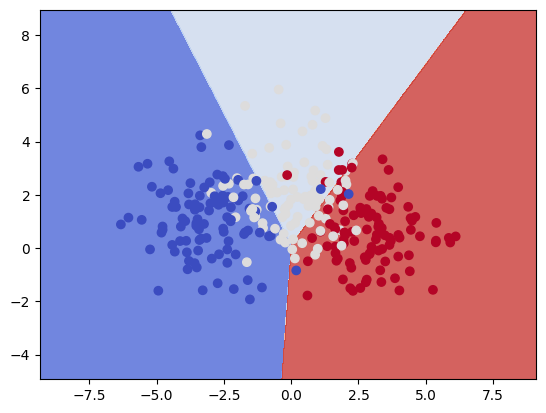

In [ ]:
#@title This will plot the boundaries of the model

def predict(data):
    outputs = model(torch.tensor(data, dtype=torch.float32))
    _, predicted = torch.max(outputs, 1)
    return predicted

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

metrics.confusion_matrix(y, predict(X))

## Question 2 - Linear Regression
You are requested by the Charles Darvin himself to predict the age of abalone from physical measurements.
The dataset consists of 7 continious features that he has collected for you.

In [ ]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

We define the following:
-	X, 2d matrix from size n x d which represents the training samples.
-	y, array from size n which represents the target value for the corresponding sample.

Implement the function Linreg_sol(X,y) which outputs the closed form solution for linear regression on X,y. <br/>
Don't use pinv

In [ ]:
def Linreg_sol(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    x_transpose = np.transpose(X_b)
    x_transpose_x = np.dot(x_transpose, X_b)
    x_transpose_x_inv = np.linalg.inv(x_transpose_x)
    x_transpose_ = np.dot(x_transpose_x_inv, x_transpose)
    return np.dot(x_transpose_, y)

Load data from https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv

In [ ]:
# Implement here
df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv', header=None)
print(df.head(3))


       0      1      2       3       4       5     6   7
0  0.455  0.365  0.095  0.5140  0.2245  0.1010  0.15  15
1  0.350  0.265  0.090  0.2255  0.0995  0.0485  0.07   7
2  0.530  0.420  0.135  0.6770  0.2565  0.1415  0.21   9


Your tasks are:
- Convert to numpy
- Preproccess the data
- Find the weight vector and the bias

In [ ]:

from sklearn.preprocessing import StandardScaler

x = df.values[:, :-1]
y = df.values[:, -1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
w = Linreg_sol (X_scaled , y)
print("Length of weight vector:", len(w))

# Suppose w is the solution
print(f'The linear line is {w[1]:.2f}x1+{w[2]:.2f}x2+{w[3]:.2f}x3+{w[4]:.2f}x4+{w[5]:.2f}x5+{w[6]:.2f}x6+{w[7]:.2f}x7+{w[0]:.2f}=0')


Length of weight vector: 8
The linear line is -0.19x1+1.33x2+0.49x3+4.53x4+-4.49x5+-1.08x6+1.19x7+9.93=0


Now, implement 'Linreg_sol_via_GD' which implement gradient descent on the linear regression problem. The stopping criterion should be based only by the iterations number recived as parameter

In [ ]:
def Linreg_sol_via_GD(X, y, lr, iter_number):
    w = np.ones(X.shape[1])
    for i in range(iter_number):
        predections = np.dot(X,w)
        error = predections - y
        gradient = (np.dot(X.T,error)) * 2/len(y)
        w = w - lr*gradient
    return w

The following code measures the number of iterations as a function of the error gap between the returned weights and the correct solution. <br/>
Conclude the complexity formula required - How many iterations do we need as a function of the error, $\varepsilon$? Make sure to include the $𝚶$ notation in your answer. <br/>
Note: This error is sometimes called 'gap'. <br/>
<font color='red'>According to the plot we can see that as the error gap decreases the number of iterations increases rapidly. Judging by the shape of the function we can approximate that T=O(1/$\varepsilon$).</font>

100%|██████████| 90/90 [00:28<00:00,  3.16it/s]


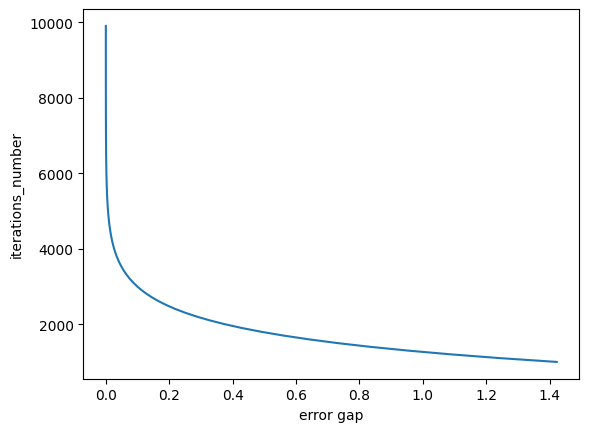

In [ ]:
w_real = w
X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]
iters = np.arange(1000, 10_000, 100)
gaps = []

for iter in tqdm(iters):
    w = Linreg_sol_via_GD(X_b, y, 0.1, iter)
    gaps.append(np.linalg.norm(w_real - w))

plt.plot(gaps, iters)
plt.ylabel("iterations_number")
plt.xlabel("error gap")
plt.show()

In the second part of the task, we will see the features dependence and try to solve it.

Calculate the the value of $\text{Cov}(X)=\frac{1}{n-1}(X-\mu)^\top (X-\mu)$? <br/>
- What can you imply from this about the features?
- Can we imply something on $X^\top X$? Must its det be 0?

Note: In your calculations, make sure the bias is not included as feature. <br/>

<font color='red'>According to the coveriance matrix we can assume that the features are highly correlated, that means the features share significant information and nearly lineary dependent,which leads to a nearly singular covariance matrix with a determinant close to zero, therefore $X^\top X$ will also have a determinant close to zero </font>

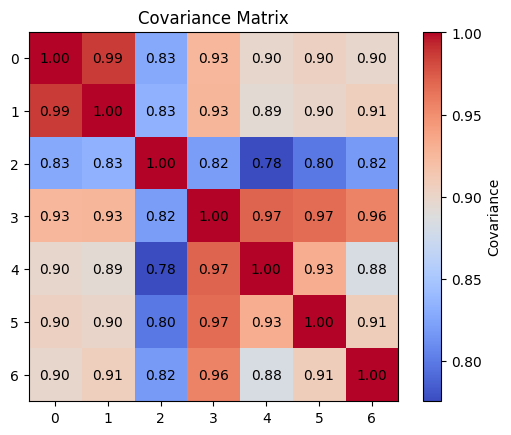

In [ ]:
# Implement here
mean = np.mean(X_scaled,axis=0)
n=X_scaled.shape[0]
cov_matrix = np.dot((X_scaled-mean).T,(X_scaled - mean))/(n-2)
plt.imshow(cov_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Covariance')
plt.title('Covariance Matrix')
for (i, j), val in np.ndenumerate(cov_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
plt.show()


Implement the solution to ridge regression using GD.

In [ ]:
def Linreg_sol_Ridge(X, y, lamda):
    n, d = X.shape
    I = np.identity(d)
    w = np.linalg.inv(X.T @ X + lamda * I) @ X.T @ y
    return w


The following code measures the mse error as function of the regularization hyperparameter lamda. <br/>Explain the origin to the mse' behaviour as function of lamda in this problem. <br/>

<font color='red'>
When using higher λ the MSE increases because the regularization in Ridge Regression gives more panelty to larger coefficients shrinking them towards zero. This results in underfitting, because we will simply the model therfore it wont capture the underlying data patterns, Which leads to higher MSE. In conlusion higher λ values increases the bias and reduce the model's accuracy due to underfitting.</font>

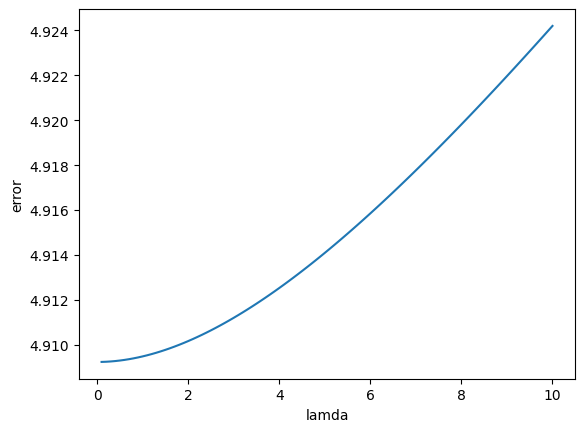

In [ ]:
mses = []
lamdas = np.arange(0.1, 10.1, 0.1)
X_for_reg = X_b
for lamda in lamdas:

    w = Linreg_sol_Ridge(X_for_reg, y, lamda)

    preds = np.dot(X_for_reg, w)
    mses.append(np.mean((preds - y) ** 2))

plt.plot(lamdas, mses)
plt.ylabel("error")
plt.xlabel("lamda")
plt.show()

## Question 3 - Decision tree

Recall the wine dataset from hw1, where we classified wine types based on their physical and chemical properties. You will do it, but this time with decision trees!

In [ ]:
# Import libraries

import numpy as np
import pandas as pd

In [ ]:
# Load the data, print the first rows

data = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw1/wine.data.csv')
data.head(3)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1


Complete this missing implementation of the following functions:
- ```calculate_entropy(self, data)``` – given data, compute the entropy, where the distribution is over its labels (target class).
- ```calculate_information_gain(self, data, feature)``` – given data and specific feature, compute the information gain given by selecting that feature.

Algorithm: The data is continuous, so create 10 thresholds between the min and max values of that feature. For each threshold, split to left tree and right tree and calculate the gain. Choose the threshold which gives the highest gain, along with the gain itself (to later compare between features) <br/>

Tip: To split the tree (represented by data df), use filter_data.
For example, when calculating the gain of 'skew' with threshold 0.5, you can create the left tree by use ```filter_data(data, 'skew', '0.5', left=True)``` to obtain only those samples.

In [ ]:
# Define the ID3 decision tree class
class DecisionTree:
	def __init__(self, max_depth=np.inf):
		self.tree = {}
		self.max_depth = max_depth

	def calculate_entropy(self, data):
		labels = data.iloc[:, -1]
		label_counts = labels.value_counts()
		probabilities = label_counts / len(labels)
		entropy = -sum(probabilities * np.log2(probabilities))
		return entropy

	def calculate_information_gain(self, data, feature):
		total_entropy = self.calculate_entropy(data)
		information_gain = total_entropy

		feature_values = data[feature]
		min_value, max_value = feature_values.min(), feature_values.max()

		values = np.linspace(min_value, max_value, num=10)# generate 10 thresholds
		best_treshold = None
		best_gain = 0
		for value in values:
			left_split = self.filter_data(data, feature, value, left=True)
			right_split = self.filter_data(data, feature, value, left=False)
			if len(left_split) == 0 or len(right_split) == 0:
				continue

			left_entropy = self.calculate_entropy(left_split)
			right_entropy = self.calculate_entropy(right_split)
			weighted_entropy = (len(left_split) / len(data)) * left_entropy + (len(right_split) / len(data)) * right_entropy
			gain = total_entropy - weighted_entropy
			if gain > best_gain:
				best_gain = gain
				best_treshold = value

		return best_gain, best_treshold

	def filter_data(self, data, feature, value, left=True):
		if left:
			return data[data[feature] <= value].drop(feature, axis=1)
		else:
			return data[data[feature] > value].drop(feature, axis=1)

	def create_tree(self, data, depth=0):
		# Recursive function to create the decision tree
		labels = data.iloc[:, -1]

		# Base case: if all labels are the same, return the label
		if len(np.unique(labels)) == 1:
			return list(labels)[0]

		if depth >= self.max_depth:
				unique_labels, label_counts = np.unique(labels, return_counts=True)
				majority_label = unique_labels[label_counts.argmax()]
				return majority_label

		features = data.columns.tolist()[:-1]
		# Base case: if there are no features left to split on, return the majority label
		if len(features) == 0:
			unique_labels, label_counts = np.unique(labels, return_counts=True)
			majority_label = unique_labels[label_counts.argmax()]
			return majority_label

		selected_feature = None
		best_gain = 0
		best_treshold = None

		for feature in features:
			gain, treshold = self.calculate_information_gain(data, feature)
			if gain >= best_gain:
				selected_feature = feature
				best_treshold = treshold
				best_gain = gain

		# Create the tree node
		tree_node = {}
		tree_node[(selected_feature, f"<={best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=True), depth+1)
		tree_node[(selected_feature, f">{best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=False), depth+1)

		# check if can unite them.
		if not isinstance(tree_node[(selected_feature, f"<={best_treshold}")], dict) and \
				not isinstance(tree_node[(selected_feature, f">{best_treshold}")], dict):
			if tree_node[(selected_feature, f"<={best_treshold}")] == tree_node[(selected_feature, f">{best_treshold}")]:
				return tree_node[(selected_feature, f"<={best_treshold}")]

		return tree_node

	def fit(self, data):
		self.tree = self.create_tree(data)

	def predict(self, X):
		X = [row[1] for row in X.iterrows()]

		# Predict the labels for new data points
		predictions = []

		for row in X:
			current_node = self.tree
			while isinstance(current_node, dict):
				split_condition = next(iter(current_node))
				feature, value = split_condition
				treshold = float(value[2:])
				if row[feature] <= treshold:
					current_node = current_node[feature, f"<={treshold}"]
				else:
					current_node = current_node[feature, f">{treshold}"]
			predictions.append(current_node)

		return predictions

	def _plot(self, tree, indent):
		depth = 1
		for key, value in tree.items():
			if isinstance(value, dict):
				print(" " * indent + str(key) + ":")
				depth = max(depth, 1 + self._plot(value, indent + 2))
			else:
				print(" " * indent + str(key) + ": " + str(value))
		return depth

	def plot(self):
		depth = self._plot(self.tree, 0)
		print(f'depth is {depth}')


You are ready - define DecisionTree, fit it on the entire data and plot the tree. <br/>
The depth of the tree should be 5

In [ ]:
dt = DecisionTree()
dt.fit(data)
dt.plot()

('Flavanoids', '<=1.3933333333333335'):
  ('Color intensity', '<=4.405555555555556'):
    ('Hue', '<=0.9022222222222223'):
      ('Proline', '<=372.0'): 2
      ('Proline', '>372.0'): 3
    ('Hue', '>0.9022222222222223'):
      ('Malic acid', '<=3.167777777777778'): 2
      ('Malic acid', '>3.167777777777778'): 3
  ('Color intensity', '>4.405555555555556'): 3
('Flavanoids', '>1.3933333333333335'):
  ('Proline', '<=745.3333333333333'):
    ('Alcohol', '<=13.231111111111112'): 2
    ('Alcohol', '>13.231111111111112'):
      ('Color intensity', '<=3.96'): 2
      ('Color intensity', '>3.96'):
        ('OD280/OD315 of diluted wines', '<=1.3'): 3
        ('OD280/OD315 of diluted wines', '>1.3'): 1
  ('Proline', '>745.3333333333333'):
    ('Alcohol', '<=12.597777777777779'): 2
    ('Alcohol', '>12.597777777777779'):
      ('Color intensity', '<=3.35'): 2
      ('Color intensity', '>3.35'): 1
depth is 5


The decision tree is pretty large (depth is 5). To solve this, lets modify our DecisionTree: <br/>
```
def __init__(self, max_depth=np.inf):
        self.tree = {}
        self.max_depth = max_depth
```

Modify the rest of the code to stop growing after max_depth. <br/>
Hint: When reached to max_depth, should we continue splitting? Which category will be best to be selected?


Using 10 thresholds, compare using max_depth=2 and max_depth=4. Based on the results, which depth is better for our problem in term of ML? <br/>
<font color='red'>In our problem we got the same accuracy for the test but when max_depth=2 we got worse training accuracy not by a lot. In this case we would prefer to choose max_depth=2 because of the test accuracy the time complixity and to prevent overfitting.</font>

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

for depth in [2, 4]:
  print(f'------------ max_depth={depth} ------------')
  dt = DecisionTree(max_depth=depth)
  dt.fit(train)
  preds = dt.predict(train)
  acc = np.mean(preds == train.iloc[:, -1])
  # Implement here
  print(f'Training accuracy is {acc}')
  preds = dt.predict(test)
  acc = np.mean(preds == test.iloc[:, -1])
  # Implement here
  print(f'Test accuracy is {acc}')
  print()

------------ max_depth=2 ------------
Training accuracy is 0.9225352112676056
Test accuracy is 0.8888888888888888

------------ max_depth=4 ------------
Training accuracy is 0.9859154929577465
Test accuracy is 0.8888888888888888



Now, use KFold (as seen in tutorials) for a cross validation search to the best depth for the tree.

100%|██████████| 5/5 [00:56<00:00, 11.24s/it]


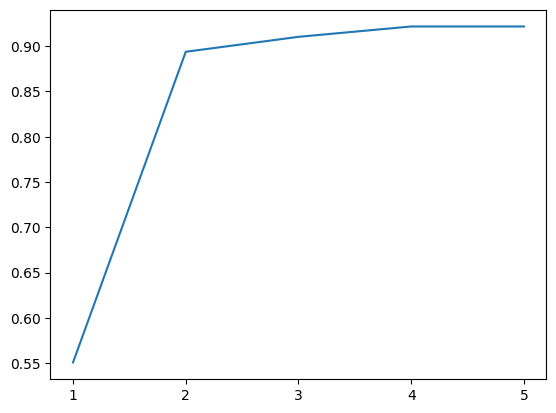

In [ ]:
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for depth in tqdm(range(1,6)):
    fold_accuracies = []
    for train_index, val_index in kf.split(data):
        train_data, val_data = data.iloc[train_index], data.iloc[val_index]
        dt = DecisionTree(max_depth=depth)
        dt.fit(train_data)
        predictions = dt.predict(val_data.drop('Class', axis=1))
        accuracy = np.mean(predictions == val_data['Class'])
        fold_accuracies.append(accuracy)
    avg_accuracy = np.mean(fold_accuracies)
    accs.append(avg_accuracy)

plt.plot(range(1,6), accs)
plt.xticks(range(1,6))
plt.show()

Use that depth and print the test score. Is it better generalizer than the first one? What do you conclude about the tuning proccess using validation? (answer to yourselves).

## Question 4 - PAC, Bias vs Variance
See attached pdf in moodle assignment!

## Question 5 - Polynomial regression - 5 pts bonus
In this problem you will extend regression to fit nonlinear functions.<br/>
The dataset contains one feature (x) and continiuos prediction (y).

In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#@title Load data

import requests
from io import BytesIO

def load_npy_file(url):
  response = requests.get(url)
  if response.status_code == 200:
    npy_data = np.load(BytesIO(response.content), allow_pickle=True).item()
    return npy_data
  else:
    return None

In [ ]:
data_dict = load_npy_file('https://sharon.srworkspace.com/ml/datasets/hw3/linreg_data_2d.npy')

x_train = data_dict['x_train']
y_train = data_dict['y_train']
x_test = data_dict['x_test']
y_test = data_dict['y_test']

Look at the plot of the training data. What do you think was the function generated the data? <br/>
<font color='red'>According to the plot we can see that the data generated by wave with a linear tend, most likely of the form 𝑦=a*sin(x)+bx</font>

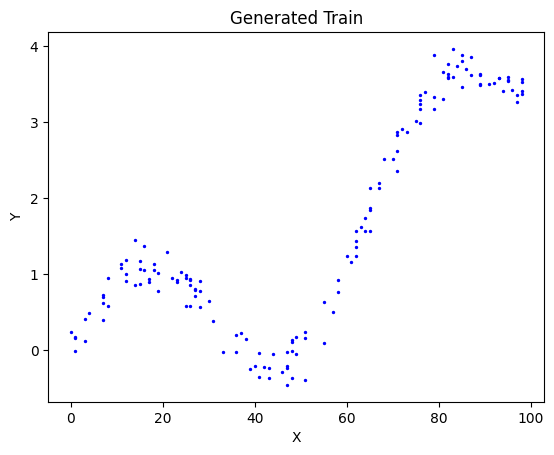

In [ ]:
plt.scatter(x_train, y_train, color='blue', s=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Train')
plt.show()

We will assume the polynomial regression problem of the following form:
$$ y=a_0+a_1x+a_2x^2+...+a_dx^d $$
The function ```get_solution``` will find the cofficients, similarly to methods done in simple linear regression. <br/>
The function ```calc``` will recieve a new sample and the cofficients found, and will predict the output.





In [ ]:
def get_solution(X, y, degree=2):
    # Generate polynomial features for each sample
    x_poly = np.hstack([X**i for i in range(1, degree + 1)])
    X_b = np.c_[np.ones((X.shape[0], 1)), x_poly]
    x_transpose = np.transpose(X_b)
    x_transpose_x = np.dot(x_transpose, X_b)
    x_transpose_x_inv = np.linalg.inv(x_transpose_x)
    x_transpose_ = np.dot(x_transpose_x_inv, x_transpose)
    return np.dot(x_transpose_, y)

def calc(X, coefs):
    # Check if X is a 2D array
    #if X.ndim == 1:
    #    X = X[:, np.newaxis]
    degree = len(coefs) - 1
    X_poly = np.hstack([X**i for i in range(degree + 1)])
    predictions = np.dot(X_poly, coefs)
    return predictions

Running the current code with $d=1$ yields a simple regressor.
- Which $d$ works best?
- According to your previous answer, which $d$ <u>is expected</u> to work the best?
- Try to explain what happens when you try $d+1$ and why? Was the solver you implemented enough?

<font color='red'>We got that using $d=4$ will give us the best answer.<br/>
Every $d$ that close and bigger than 4 like 5 will get us good results, but if we used higher values like 6 or higher will get overfitting therfore worst results in addition to higher runtime,in the other hand using low values will lead to underfitting.<br/>
</font>

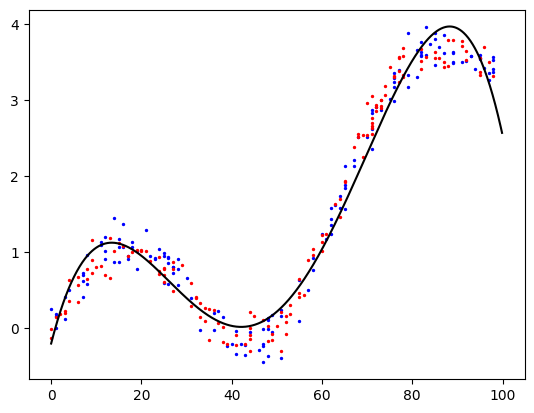

In [ ]:
xx = np.arange(0, 100, 0.1)
yy = []

weights = get_solution(x_train, y_train, 4)

for samp in xx:
  yy.append(calc(samp, weights))

plt.scatter(x_train, y_train, color='blue', s=2, label='train')
plt.scatter(x_test, y_test, color='red', s=2, label='test')
plt.plot(xx, yy, color='black')
plt.show()